# Analysis between the original dataset and the generated dataset

Import all the necessary libraries used in the project:

In [1]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tqdm import tqdm
    import numpy as np
    from tqdm import tqdm
    from matplotlib.ticker import MaxNLocator
    import cv2
    import pywt
    from matplotlib.ticker import MaxNLocator, ScalarFormatter
    
except Exception as e:
    print(f"Some module are missing: {e}\n")
    
colors = ["#276CB3", "#F0741E"]

plt.style.use("seaborn-v0_8-paper")

package_path=Path("/home/tom/git_workspace/tesi/VAE_DefectedGraphene")

save_path=package_path.joinpath("data","analysis","plots")
save_path.mkdir(exist_ok=True, parents=True)

Define the functions to extract the frequency features:

In [2]:
def calculate_entropy(data: np.ndarray, bins: int = 256) -> float:
    data_flat = data.flatten()
    histogram, _ = np.histogram(data_flat, bins=bins, range=(0, bins), density=True)
    entropy = -np.sum(histogram * np.log2(histogram + 1e-10))
    return entropy


def clalc_shift_spect(img):
    f = np.fft.fft2(img)

    coeffs = pywt.wavedec2(img, "haar", level=2)
    return f, coeffs


def extract_frequency_features(
    image: Path | np.ndarray, wavelet: str = "db4", bins: int = 256, invert_mask=False
) -> dict:
    image = image.resolve()
    if isinstance(image, Path):
        img = cv2.imread(str(image), cv2.IMREAD_GRAYSCALE)
    else:
        img = image.copy()
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
    if invert_mask:
        img = cv2.bitwise_not(img)

    # f = np.fft.fft2(img)
    f, coeffs = clalc_shift_spect(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-10)

    mean_freq = np.mean(magnitude_spectrum)
    std_freq = np.std(magnitude_spectrum)
    max_freq = np.max(magnitude_spectrum)
    min_freq = np.min(magnitude_spectrum)
    median_freq = np.median(magnitude_spectrum)
    energy = np.sum(np.abs(fshift) ** 2)

    rows, cols = magnitude_spectrum.shape
    crow, ccol = rows // 2, cols // 2

    histogram, _ = np.histogram(
        magnitude_spectrum, bins=bins, range=(0, bins), density=True
    )
    entropy = -np.sum(histogram * np.log2(histogram + 1e-10))

    low_freq_energy = np.sum(magnitude_spectrum[:crow, :ccol])
    high_freq_energy = np.sum(magnitude_spectrum[crow:, ccol:])
    frequency_contrast = high_freq_energy - low_freq_energy

    # coeffs = pywt.wavedec2(img, wavelet, level=2)
    cA2, (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs

    wavelet_features = {
        "wavelet_energy_A2": np.sum(np.square(cA2)),
        "wavelet_energy_H2": np.sum(np.square(cH2)),
        "wavelet_energy_V2": np.sum(np.square(cV2)),
        "wavelet_energy_D2": np.sum(np.square(cD2)),
        "wavelet_std_A2": np.std(cA2),
        "wavelet_std_H2": np.std(cH2),
        "wavelet_std_V2": np.std(cV2),
        "wavelet_std_D2": np.std(cD2),
        "wavelet_energy_H1": np.sum(np.square(cH1)),
        "wavelet_energy_V1": np.sum(np.square(cV1)),
        "wavelet_energy_D1": np.sum(np.square(cD1)),
        "wavelet_std_H1": np.std(cH1),
        "wavelet_std_V1": np.std(cV1),
        "wavelet_std_D1": np.std(cD1),
        "wavelet_entropy_A2": calculate_entropy(cA2, bins),
        "wavelet_entropy_H2": calculate_entropy(cH2, bins),
        "wavelet_entropy_V2": calculate_entropy(cV2, bins),
        "wavelet_entropy_D2": calculate_entropy(cD2, bins),
        "wavelet_entropy_H1": calculate_entropy(cH1, bins),
        "wavelet_entropy_V1": calculate_entropy(cV1, bins),
        "wavelet_entropy_D1": calculate_entropy(cD1, bins),
    }

    frequency_features = {
        "mean_frequency": mean_freq,
        "std_frequency": std_freq,
        "max_frequency": max_freq,
        "min_frequency": min_freq,
        "median_frequency": median_freq,
        "energy": energy,
        "entropy": entropy,
        "low_frequency_energy": low_freq_energy,
        "high_frequency_energy": high_freq_energy,
        "frequency_contrast": frequency_contrast,
    }

    frequency_features.update(wavelet_features)

    return frequency_features

Extract the frequency features from the generated dataset:

In [3]:
images_path=package_path.joinpath("results","VAE","generated_dataset")
frequency_dict = {}

images = [f for f in images_path.iterdir() if f.suffix.lower() ==".png"]
for image in tqdm(images):
    dict_img = extract_frequency_features(image, invert_mask=True)
    if int(np.loadtxt(image.with_suffix(".txt"))) >= 512:
        print("Warning!")
        continue
    else:
        dict_img["n_atoms"] = int(np.loadtxt(image.with_suffix(".txt")))
        dict_img["file_name"] = image.stem
        frequency_dict[f"{image.stem}"] = dict_img

frequency_df = pd.DataFrame.from_dict(frequency_dict, orient="index")

100%|██████████| 20/20 [00:00<00:00, 197.10it/s]


Save the dataframe with the extracted features

In [ ]:
frequency_df.to_csv(package_path.joinpath("data","analysis","generated_df.csv"), index=False)

Plot the comparison:

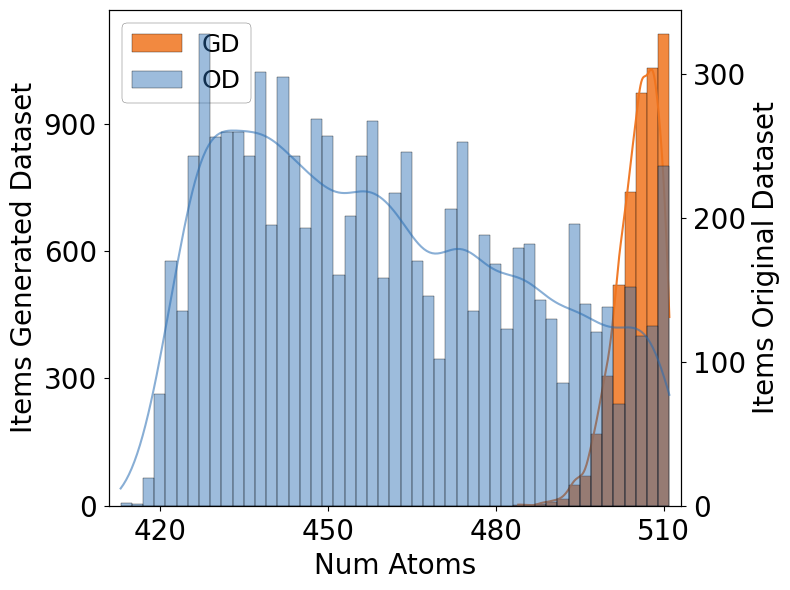

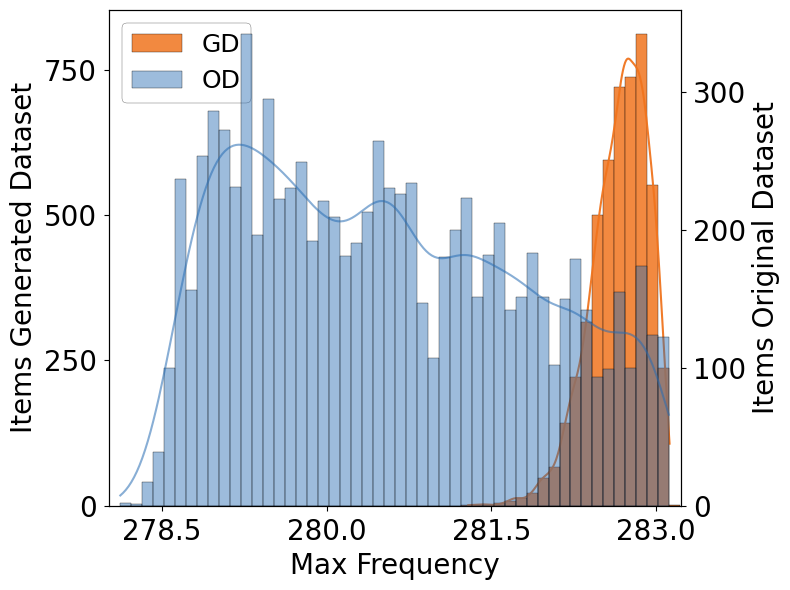

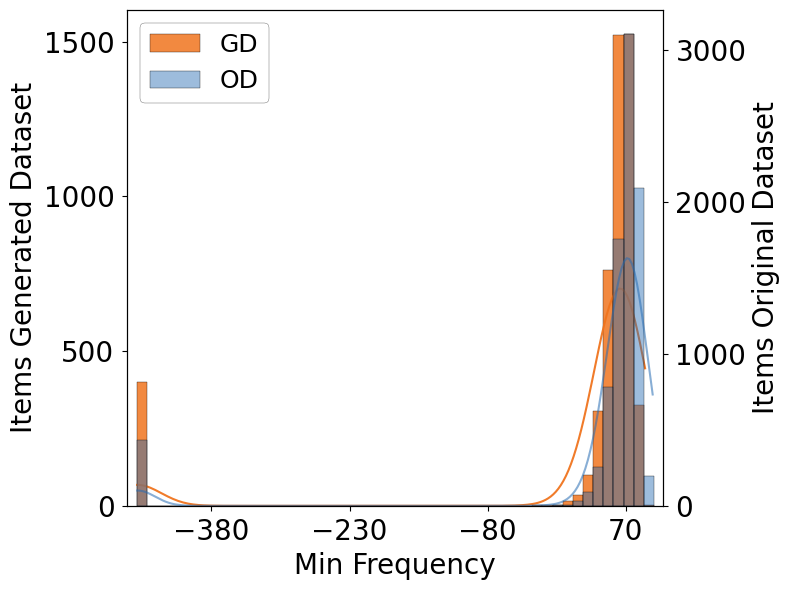

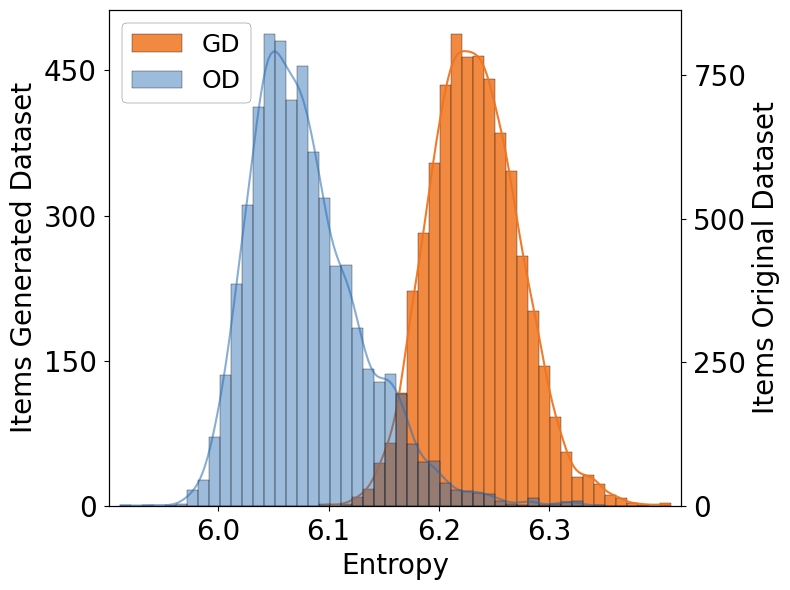

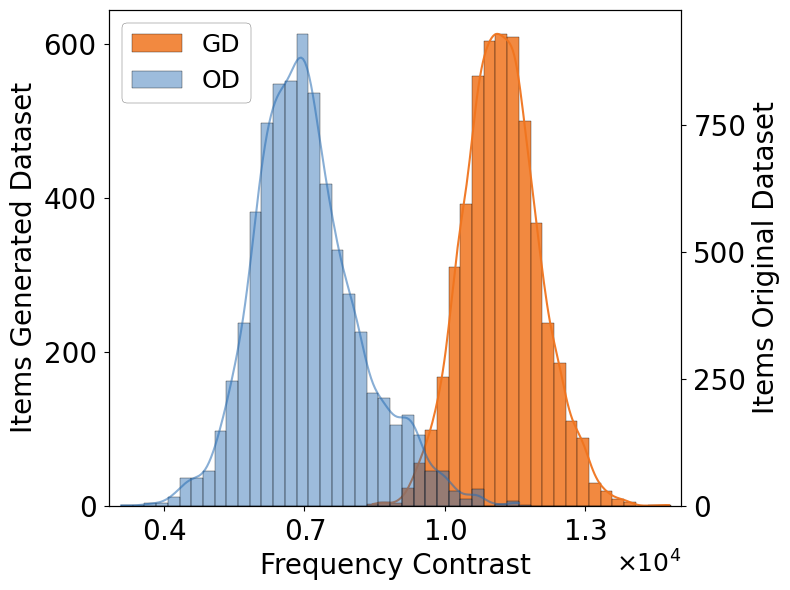

In [5]:
generated_df = pd.read_csv(package_path.joinpath("data","analysis","generated_df.csv")) 
original_df = pd.read_csv(package_path.joinpath("data","analysis","original_df.csv"))


target_list = ["n_atoms","max_frequency","min_frequency","entropy","frequency_contrast"]
target_labels = {
    "n_atoms": ("Num Atoms", "Density"),
    "max_frequency": ("Max Frequency", "Density"),
    "min_frequency": ("Min Frequency", "Density"),
    "entropy": ("Entropy", "Density"),
    "frequency_contrast": ("Frequency Contrast", "Density"),
}
target_ticks = {
    "n_atoms" : [420, 450,480, 510],
    "max_frequency": [278.5,280,281.5,283],
    "min_frequency": [-380, -230,-80, 70],
    "entropy": [6.0, 6.1, 6.2 ,6.3],
    "frequency_contrast": [4000, 7000, 10000,13000],
}

target_binwidth = {
    "n_atoms" : 2,
    "max_frequency": 0.1,
    "min_frequency": 11,
    "entropy":0.01,
    "frequency_contrast":250
}

for target in target_list:
    # Calcola i bordi dei bins comuni
    min_value = min(original_df[target].min(),generated_df[target].min())
    max_value = max(original_df[target].max(),generated_df[target].max())
    
    if target in target_binwidth.keys():
        binwidth = target_binwidth[target]
        bins = np.arange(min_value, max_value + binwidth, binwidth)
    else:
        bins=50


    fig, ax1 = plt.subplots(figsize=(8,6))
    sns.histplot(data=generated_df, x=target, ax=ax1, bins=bins, kde=True, label='GD', color=colors[1], stat='count', alpha=0.85, line_kws={'alpha':0.95,"linewidth":1.5})
    ax2 = ax1.twinx()
    sns.histplot(data=original_df, x=target, ax=ax2, bins=bins, kde=True, label='OD', color=colors[0], stat='count', alpha=0.45, line_kws={'alpha':0.55,"linewidth":1.5})

    # Sincronizza i limiti degli assi
    if target in target_binwidth.keys():
        ax1.set_xlim([min_value-binwidth, max_value+binwidth])
        ax2.set_xlim([min_value-binwidth, max_value+binwidth])
    else:
        ax1.set_xlim([min_value, max_value])
        ax2.set_xlim([min_value, max_value])

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2  # Combina le linee di entrambe le legende
    labels = labels1 + labels2  # Combina le etichette

    ax1.legend(lines, labels, loc='upper left', fontsize=18, edgecolor='black', ncol=1)
    ax1.tick_params(axis="both", which="major", labelsize=20)
    ax2.tick_params(axis="both", which="major", labelsize=20)
    if target in target_labels.keys():
        ax1.set_xlabel(target_labels[target][0],size=20)
    ax1.set_ylabel('Items Generated Dataset',size=20)
    ax2.set_ylabel('Items Original Dataset',size=20)
    if target in target_ticks:
        ax1.set_xticks(target_ticks[target])
    else:
        ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    if target == "frequency_contrast":
        ax1.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
        ax1.xaxis.offsetText.set_fontsize(18)
    plt.tight_layout()
    fig.savefig(save_path.joinpath(f"distribution_{target}_overlap_datasets.png"),dpi=300,bbox_inches="tight")
    plt.show()
    plt.close()